## Sommaire
1. <a href="#M1">Correction des données</a>
2. <a href="#M2">Désaisonnalisation</a>
3. <a href="#M3">Prévisions, modèles Holt-Winters et Sarima</a>

In [1]:
import time
import scipy
import pylab
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot, lag_plot

from joblib import dump, load
from collections import Counter

from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox

import statsmodels.api as sm
import statsmodels.formula.api as smf

import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error as mse

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
#from pmdarima.arima import auto_arima
#from pmdarima.arima import OCSBTest, ADFTest

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

rng = np.random.default_rng(1)
sns.set(font_scale=1.2, style='whitegrid')

In [2]:
# sns.set()

In [3]:
df = pd.read_csv('consommation.csv', index_col='Date', parse_dates=True)
df = df.asfreq('MS')
df

,Consommation_GW
Date,
2012-01-01,101573.076
2012-02-01,108364.070
2012-03-01,85891.077
2012-04-01,79899.382
2012-05-01,70077.667
...,...
2021-08-01,61095.998
2021-09-01,64161.309
2021-10-01,73117.128


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2012-01-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Consommation_GW  120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [5]:
# # Export
# df.to_csv('df_elec.csv', index=True)

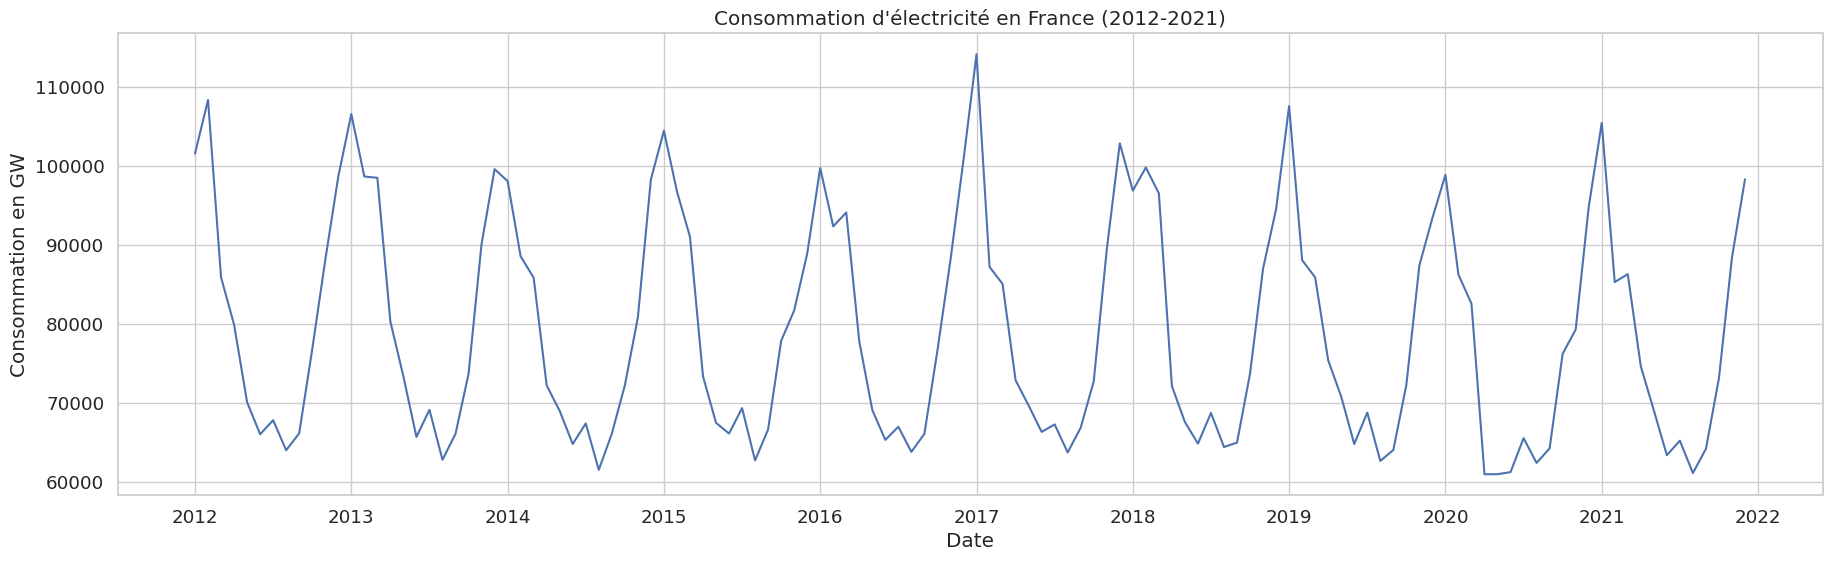

In [6]:
ax = df['Consommation_GW'].plot(figsize=(22, 6))
ax.autoscale(axis = 'both', tight = False)
ax.set(ylabel='Consommation en GW', xlabel='Date', title='Consommation d\'électricité en France (2012-2021)')
plt.show()

In [7]:
# ax = df['Consommation_GW']['2021-01-01':'2021-12-01'].plot(figsize=(22, 6), title='Consommation d\'électricité en France (2021)', fontsize=15)
# ax.set(ylabel='Consommation en GW', xlabel='');

In [8]:
df[:3]

,Consommation_GW
Date,
2012-01-01,101573.076
2012-02-01,108364.070
2012-03-01,85891.077


In [9]:
df[-3:]

,Consommation_GW
Date,
2021-10-01,73117.128
2021-11-01,88412.990
2021-12-01,98325.920


# <a name="M1">Mission 1</a>

## Correction des données de consommation mensuelles de l'effet température.

- Le degré jour (dju) est une valeur représentative de l’écart entre la température d’une journée et un seuil de température préétabli (18 °C dans le cas des DJU ou Degré Jour Unifié). 
- Sommés sur une période, ils permettent de calculer les besoins de chauffage et de climatisation d’un bâtiment.

In [10]:
dju = pd.read_excel('dju.xlsx', usecols=np.arange(13))

In [11]:
dju[-3:]

,Date,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC
10,2011,414.2,324.6,275.7,107.6,71.2,44.6,32.5,19.7,30.8,142.2,248.0,331.8
11,2010,531.8,390.7,321.9,202.7,169.1,39.6,0.0,22.5,72.0,194.3,329.3,551.1
12,2009,513.8,386.7,322.2,154.8,108.5,54.2,4.6,2.3,43.1,170.6,232.6,438.8


In [12]:
dju[:3]

,Date,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC
0,2021,421.1,324.5,301.6,274.5,162.7,3.7,3.0,7.0,40.0,150.0,290.0,370.0
1,2020,367.0,270.1,297.9,111.7,94.3,27.3,3.9,6.5,39.7,166.2,246.3,353.1
2,2019,433.4,288.5,259.8,197.6,147.1,31.2,3.2,2.9,37.7,146.5,295.5,347.7


In [13]:
col_names = ['Date', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
dju.columns = col_names
dju = dju.melt(id_vars = 'Date', value_vars = dju.columns[1:], value_name = 'dju')
dju['Date'] = dju['Date'].astype('str') + '-' + dju['variable']
dju['Date'] = pd.to_datetime(dju['Date'], format='%Y-%m-%d')
dju = dju.set_index('Date')
dju = dju.drop(columns='variable')
dju = dju.sort_index()
dju.index = dju.index.to_period('M')
dju.index=dju.index.to_timestamp()
dju = dju.loc['2012-01':, :]

In [14]:
dju.index.min()

Timestamp('2012-01-01 00:00:00', freq='MS')

In [15]:
dju.index.max()

Timestamp('2021-12-01 00:00:00', freq='MS')

In [16]:
df[:3]

,Consommation_GW
Date,
2012-01-01,101573.076
2012-02-01,108364.070
2012-03-01,85891.077


In [17]:
dju[:3]

,dju
Date,
2012-01-01,361.5
2012-02-01,468.6
2012-03-01,241.4


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2012-01-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Consommation_GW  120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [19]:
dju.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2012-01-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dju     120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [20]:
df

,Consommation_GW
Date,
2012-01-01,101573.076
2012-02-01,108364.070
2012-03-01,85891.077
2012-04-01,79899.382
2012-05-01,70077.667
...,...
2021-08-01,61095.998
2021-09-01,64161.309
2021-10-01,73117.128


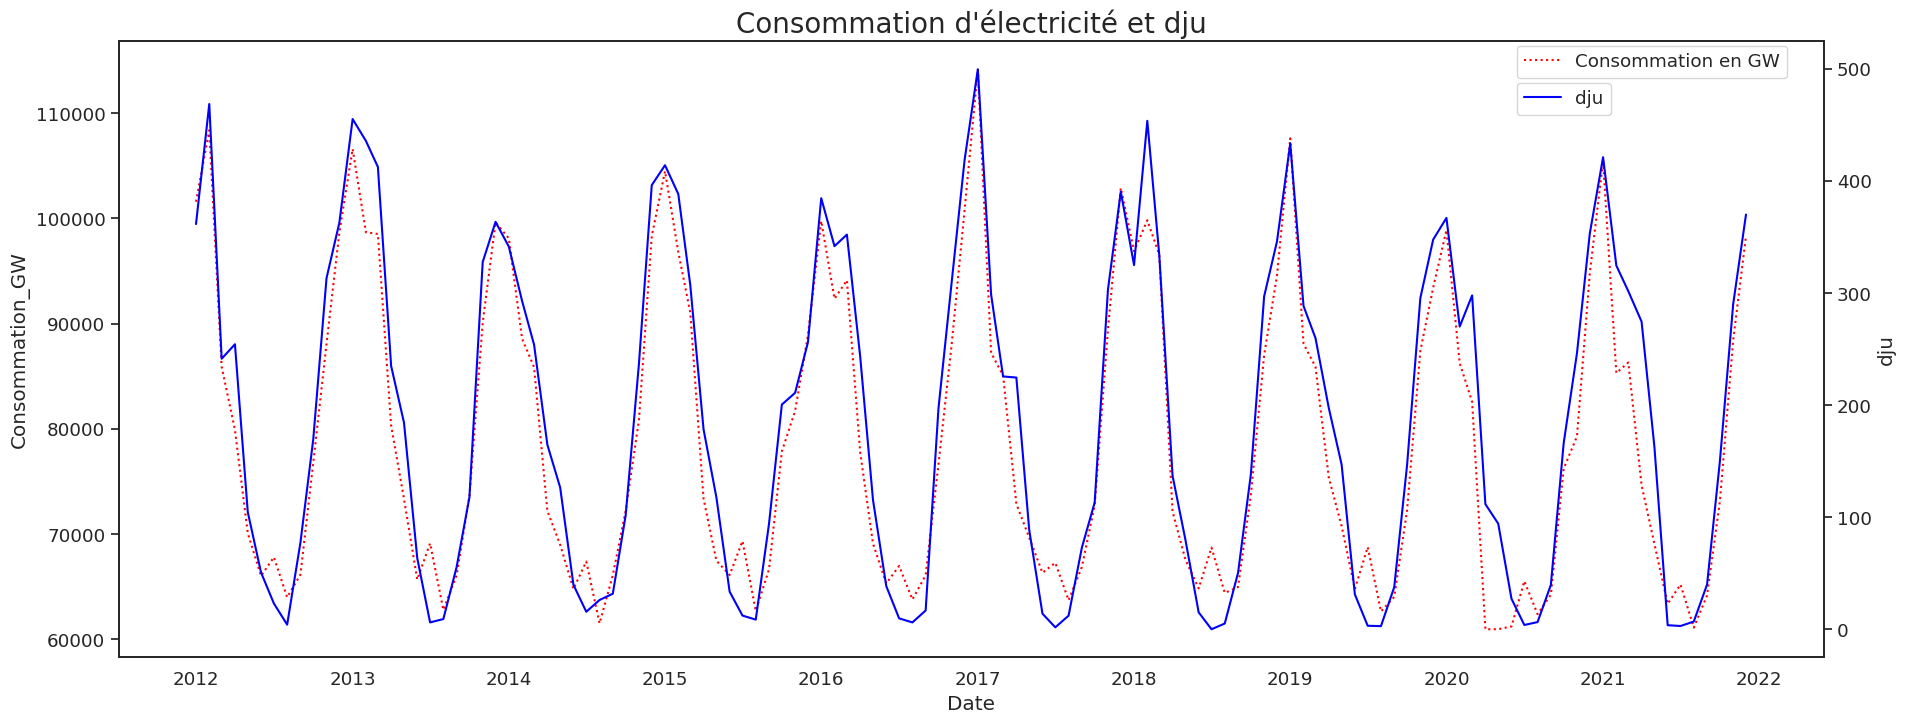

In [21]:
sns.set(font_scale=1.2, style='white')
fig = plt.figure(figsize=(22, 8))
ax = sns.lineplot(data=df, x=df.index, y='Consommation_GW', color='red', linestyle='dotted', label='Consommation en GW')
ax2 = plt.twinx()
ax2 = sns.lineplot(data=dju, x=df.index, y='dju', color='blue', ax=ax2, label='dju')
plt.title('Consommation d\'électricité et dju', fontsize=20)
ax.legend(loc=(.82, .94))
ax2.legend(loc=(.82, .88))
plt.show()
sns.set(font_scale=1.2, style='whitegrid')

In [22]:
data = pd.merge(df, dju, on='Date')
data

,Consommation_GW,dju
Date,,
2012-01-01,101573.076,361.5
2012-02-01,108364.070,468.6
2012-03-01,85891.077,241.4
2012-04-01,79899.382,254.3
2012-05-01,70077.667,104.6
...,...,...
2021-08-01,61095.998,7.0
2021-09-01,64161.309,40.0
2021-10-01,73117.128,150.0


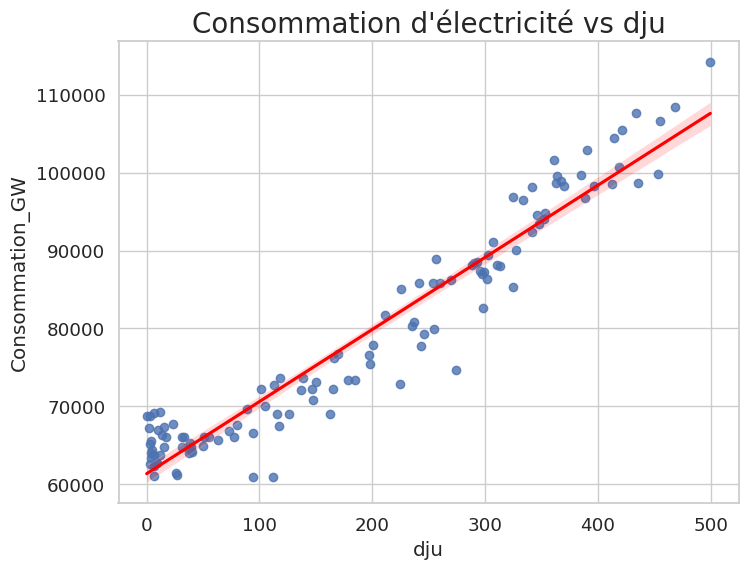

In [23]:
fig = plt.figure(figsize=(8, 6))
ax = sns.regplot(data=data, x='dju', y='Consommation_GW', line_kws={'color':'red'})
plt.title('Consommation d\'électricité vs dju', fontsize=20)
plt.show()

In [24]:
# # ADF Test
# result = sts.adfuller(data['Consommation_GW'])
# print(f'ADF Consommation_GW p-value: {result[1]}')
# result = sts.adfuller(data['dju'])
# print(f'ADF dju p-value: {result[1]}')

In [25]:
# data_diff = data.apply(lambda x: x.diff().dropna())
# sts.grangercausalitytests(data_diff[['Consommation_GW', 'dju']], maxlag=2)

In [26]:
# corr = data.corr()
# corr

In [27]:
# Scipy pearsonr
print(f"R = {st.pearsonr(data['Consommation_GW'], data['dju'])[0]}")

R = 0.9631024104386768


## Correction des données de consommation mensuelle

#### Nous allons utiliser un modèle de régression linéaire, tel que :

- consommation totale = a(dju) + b + résidu

#### Ensuite la consommation totale est corrigée de la variabilité due à l'utilisation du chauffage électrique en période froide : 

- consommation_corr = consommation_totale - a(dju)

a(dju) correspond à la consommation estimée d'électricité due au chauffage électrique.

In [28]:
reg = smf.ols('Consommation_GW ~ dju', data=data).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:        Consommation_GW   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1511.
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           4.15e-69
Time:                        16:07:22   Log-Likelihood:                -1158.9
No. Observations:                 120   AIC:                             2322.
Df Residuals:                     118   BIC:                             2327.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.136e+04    569.889    107.668      0.0

In [29]:
# Récupération du coefficient a

_, a = reg.params
print(f'Coefficient a = {np.round(a, 2)}')

Coefficient a = 92.55


In [30]:
# Calcul

data['Consommation_GW_corr'] = data['Consommation_GW'] - (a*data['dju'])
data

,Consommation_GW,dju,Consommation_GW_corr
Date,,,
2012-01-01,101573.076,361.5,68116.177168
2012-02-01,108364.070,468.6,64995.044294
2012-03-01,85891.077,241.4,63549.457697
2012-04-01,79899.382,254.3,56363.865062
2012-05-01,70077.667,104.6,60396.915637
...,...,...,...
2021-08-01,61095.998,7.0,60448.146570
2021-09-01,64161.309,40.0,60459.300830
2021-10-01,73117.128,150.0,59234.597364


In [31]:
data = data.asfreq('MS')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2012-01-01 to 2021-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Consommation_GW       120 non-null    float64
 1   dju                   120 non-null    float64
 2   Consommation_GW_corr  120 non-null    float64
dtypes: float64(3)
memory usage: 3.8 KB


In [32]:
# data['Consommation_GW_corr_log'] = np.log(data['Consommation_GW_corr'])
# data['Consommation_GW_corr'].plot(figsize=(20, 5), title='Consommation d\'électricité corrigée')
# data['Consommation_GW_corr_log'].plot(figsize=(20, 5), title='Log de consommation d\'électricité corrigée')
# plt.show()

In [33]:
a = df.index
a

DatetimeIndex(['2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01',
               ...
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='Date', length=120, freq='MS')

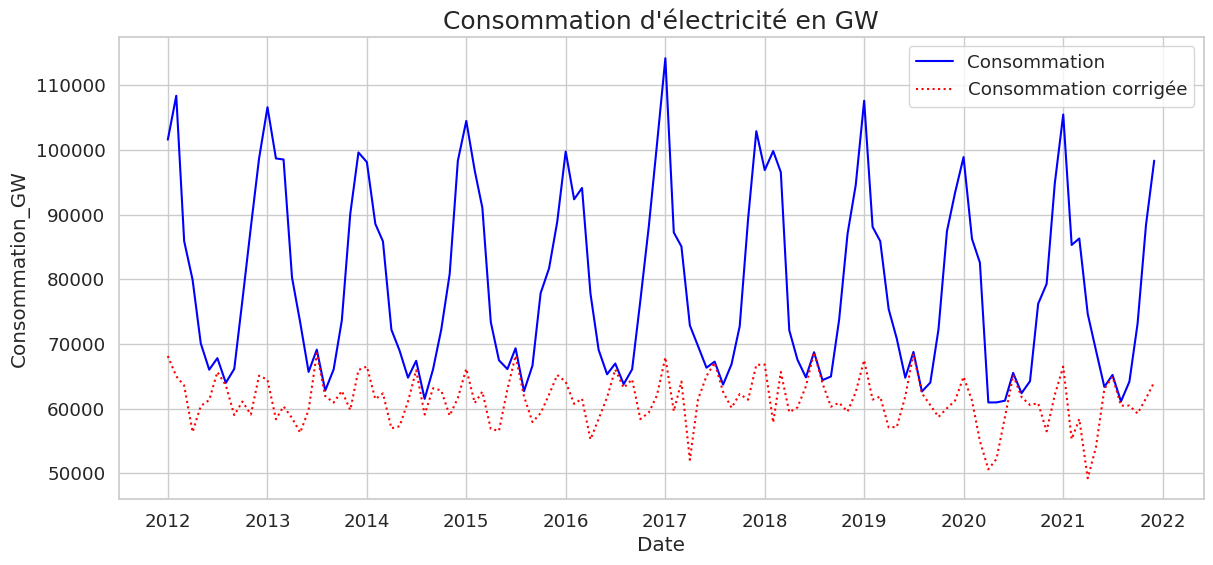

In [34]:
fig = plt.figure(figsize=(14, 6))
ax1 = sns.lineplot(data=data, x=data.index, y='Consommation_GW', color='blue', label='Consommation')
ax2 = sns.lineplot(data=data, x=data.index, y='Consommation_GW_corr', color='red', linestyle='dotted', label='Consommation corrigée')
plt.title('Consommation d\'électricité en GW', fontsize=18)
# plt.savefig('mission_1.png', transparent=True)
plt.show()

In [35]:
# ax = df['Consommation_GW']['2021-01-01':'2021-12-01'].plot(figsize=(22, 6), title='Consommation d\'électricité en France (2021)', fontsize=15)

In [36]:
# calcul de variance

print('La correction a réduit la variance de la série:\n')

print(f"- Standard deviation pour Consommation_GW: \t{int(np.std(data['Consommation_GW']))}")
print(f"- Standard deviation pour Consommation_GW_corr:  {int(np.std(data['Consommation_GW_corr']))}")

La correction a réduit la variance de la série:

- Standard deviation pour Consommation_GW: 	14061
- Standard deviation pour Consommation_GW_corr:  3784


In [37]:
# sns.set(font_scale=1.2, style='white')
# fig = plt.figure(figsize=(18, 8))
# ax = sns.lineplot(data=data, x=data.index, y='Consommation_GW_corr', color='blue', alpha=0.5, label='Consommation_GW_corr')
# ax2 = plt.twinx()
# ax2 = sns.lineplot(data=data, x=data.index, y='Consommation_GW_corr_log', color='red', linestyle='dotted', alpha=0.8, ax=ax2, label='Consommation_GW_corr_log')
# plt.title('Conso_corr et log(Conso_corr)', fontsize=20)
# ax.legend(loc=(.80, .94))
# ax2.legend(loc=(.80, .88))
# plt.show()
# sns.set(font_scale=1.2, style='whitegrid')

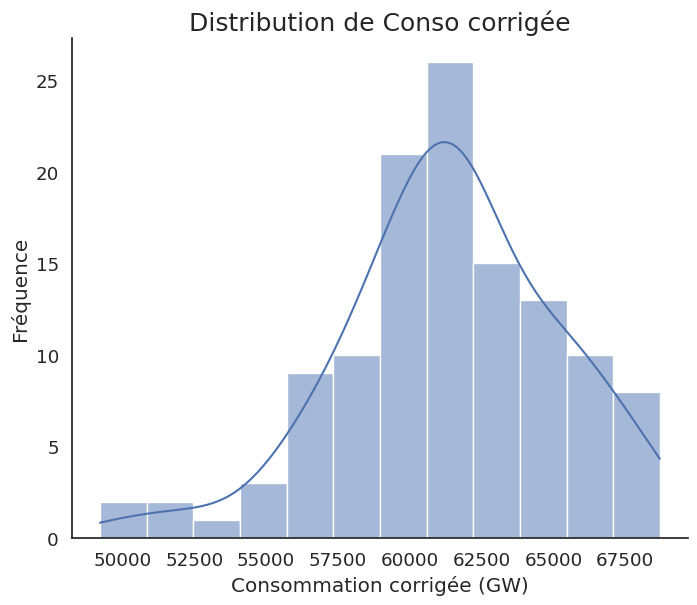

In [38]:
sns.set(font_scale=1.2, style='white')
sns.displot(data, x='Consommation_GW_corr', log_scale=False, bins=12, height=6, aspect=1.2, kde=True)
plt.ylabel('Fréquence')
plt.xlabel('Consommation corrigée (GW)')
plt.title('Distribution de Conso corrigée', fontsize=18)
plt.show()
sns.set(font_scale=1.2, style='whitegrid')

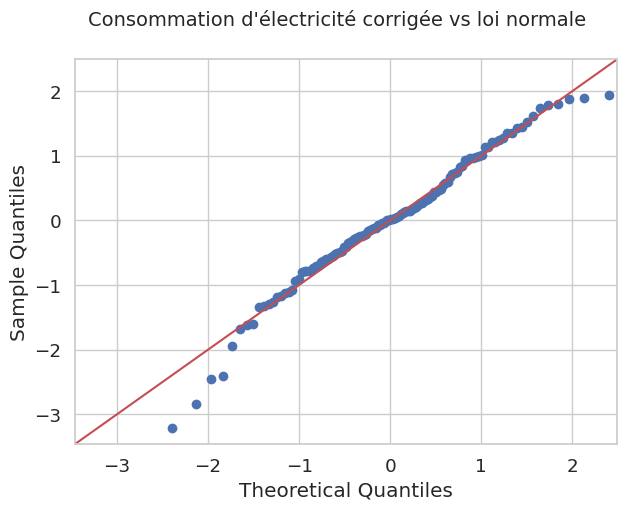

In [39]:
fig = sm.qqplot(data['Consommation_GW_corr'], fit=True, line='45')
fig.set_size_inches(7, 5)
fig.suptitle('Consommation d\'électricité corrigée vs loi normale', fontsize=14)
plt.show()

In [40]:
# skewed à gauche

In [41]:
print('Statistiques pour Conso_corr :\n')
print(f"mean: {data['Consommation_GW_corr'].mean()}")
print(f"median: {data['Consommation_GW_corr'].median()}")
print(f"std: {data['Consommation_GW_corr'].std()}")
print(f"skew: {data['Consommation_GW_corr'].skew()}")
print(f"kurt: {data['Consommation_GW_corr'].kurt()}")

Statistiques pour Conso_corr :

mean: 61359.04133674688
median: 61409.992470541765
std: 3800.2919392964845
skew: -0.4356038505665721
kurt: 0.5762168695294982


# <a name="M2">Mission 2</a>

## Désaisonnaliser la consommation par les moyennes mobiles.

In [42]:
# # A window-size equal to the seasonal duration (ex: 12 for a month-wise series), will effectively nullify the seasonal effect.

# s_dec_additive = seasonal_decompose(data['Consommation_GW'], model = 'additive', extrapolate_trend='freq', period=12)

# # fig = s_dec_additive.plot()
# # fig.set_size_inches(22, 15)
# # fig.tight_layout()
# # plt.show()

# # Tendance

# s_dec_additive.trend.plot(figsize=(22, 6))
# plt.title('Désaisonnalisation par moyennes mobiles (fenêtre = 12), il ne reste que la tendance.', fontsize=18)
# plt.show()

In [43]:
# A window-size equal to the seasonal duration (ex: 12 for a month-wise series), will effectively nullify the seasonal effect.

s_dec_additive = seasonal_decompose(data['Consommation_GW_corr'], model = 'additive', extrapolate_trend='freq', period=12)

# fig = s_dec_additive.plot()
# fig.set_size_inches(22, 15)
# fig.tight_layout()
# plt.show()

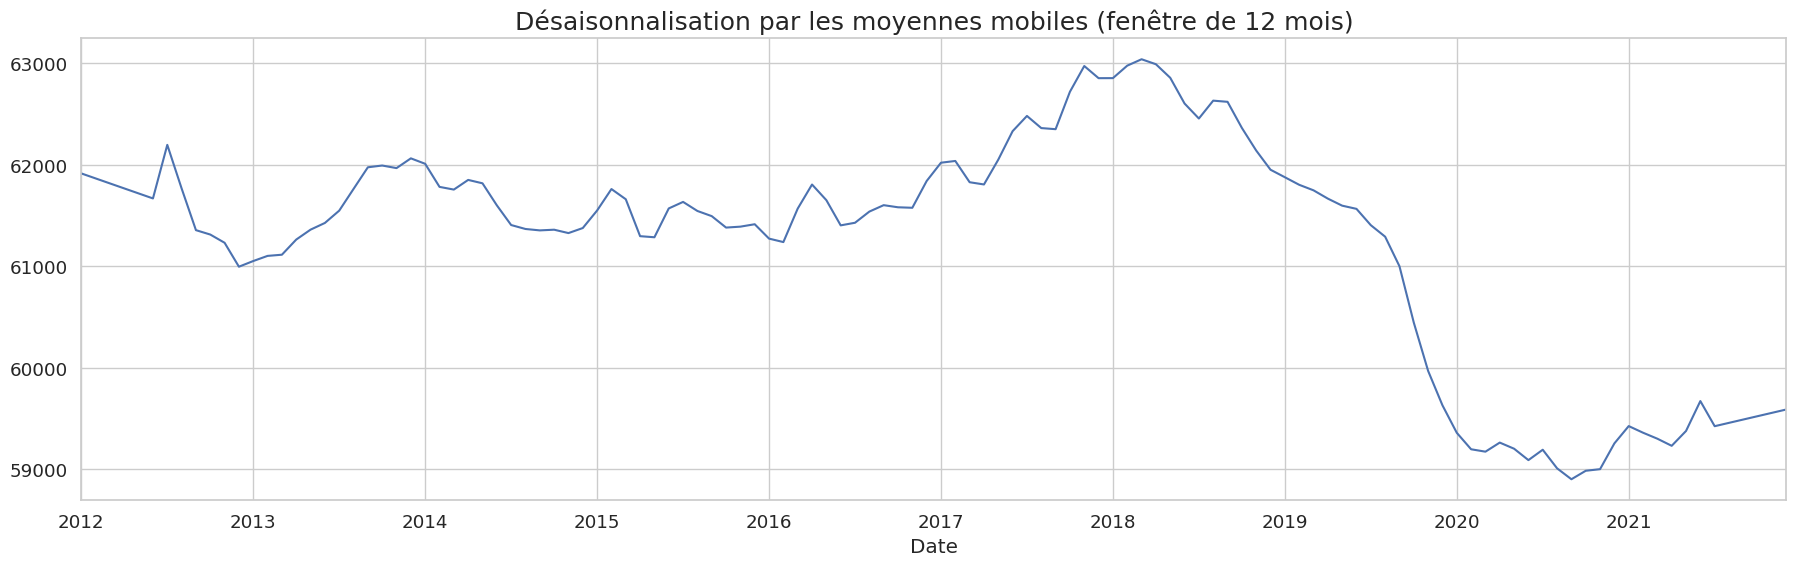

In [44]:
# Tendance

s_dec_additive.trend.plot(figsize=(22, 6))
plt.title('Désaisonnalisation par les moyennes mobiles (fenêtre de 12 mois)', fontsize=18)
plt.show()

- Il n'y a pas de tendance dans la série.
- On constate une hausse légère de la consommation corrigée en 2018 et une forte chute en 2020.

In [45]:
# # Moving Average
# data_ma = data['Consommation_GW_corr'].rolling(12, center=True, closed='both').mean()

# # Plot
# plt.figure(figsize=(22, 6))
# plt.plot(data_ma)
# plt.title('Désaisonnalisation par moyennes mobiles (window-size = 12)', fontsize=20)
# plt.show()

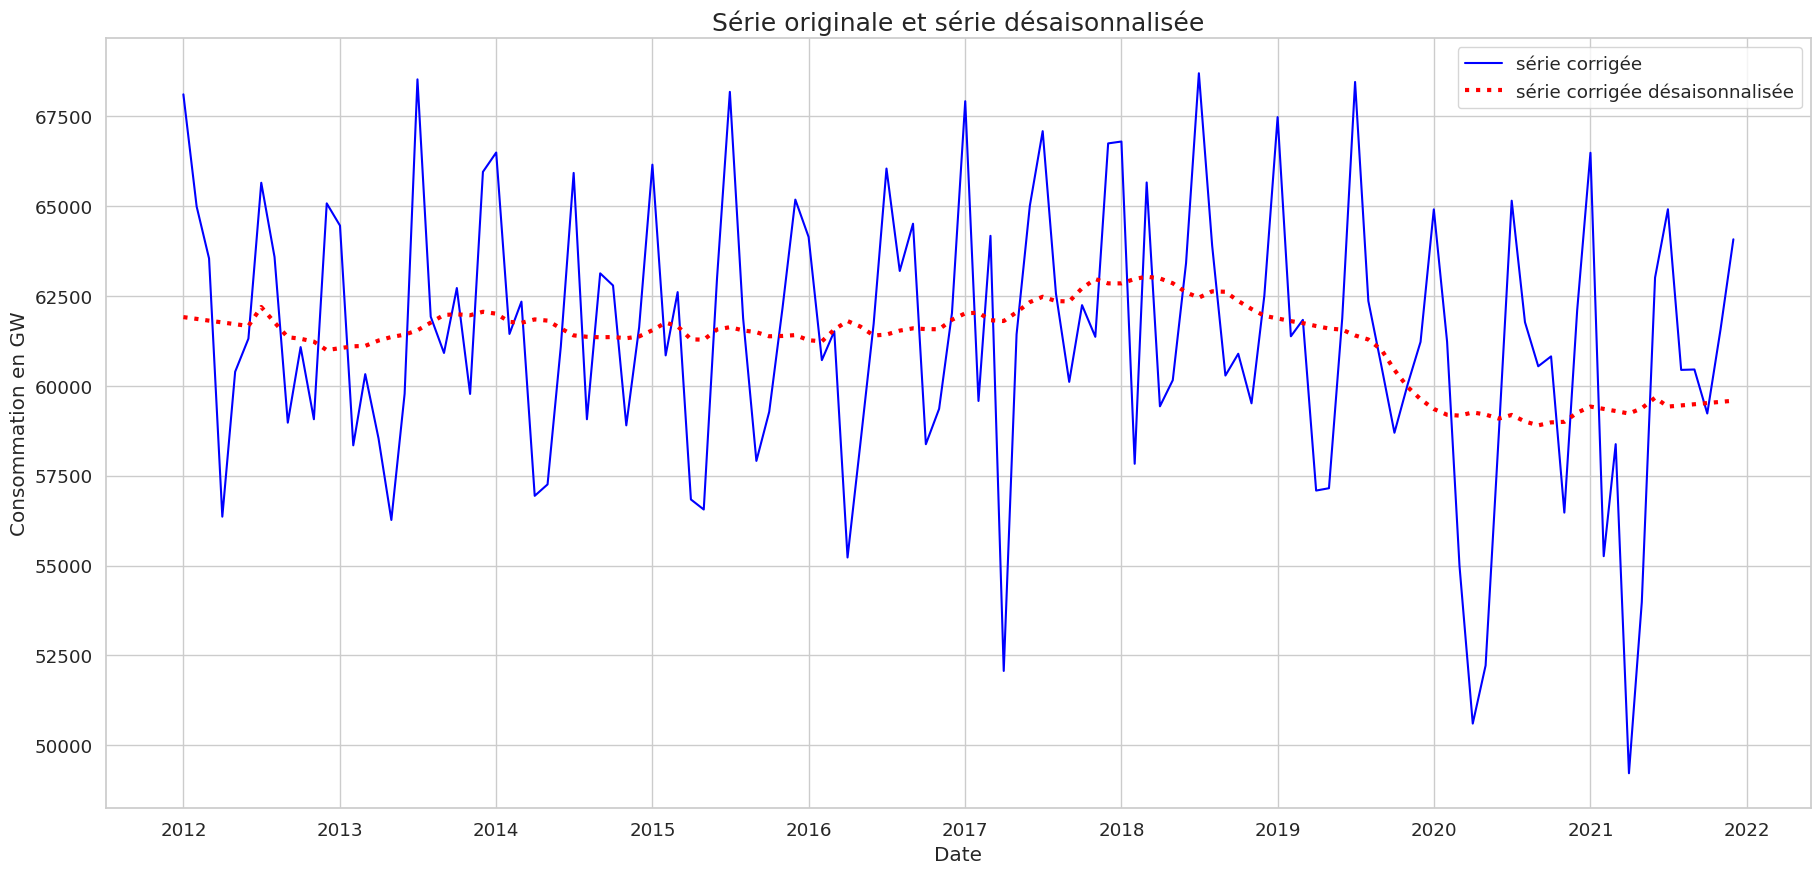

In [46]:
fig, ax = plt.subplots(figsize=(22, 10))
_ = ax.set_title('Série originale et série désaisonnalisée', fontsize=18)
_ = ax.plot(s_dec_additive.observed.index, s_dec_additive.observed, markersize=20, color='blue', label='série corrigée')
_ = ax.plot(s_dec_additive.trend.index, s_dec_additive.trend, markersize=20,  color='red', linestyle='dotted', linewidth=3, label='série corrigée désaisonnalisée')
_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('Consommation en GW')
_ = ax.legend()
# plt.savefig('mission_2.png', transparent=True)
plt.show()

In [47]:
# # Deseasonalize
# deseasonalized = data['Consommation_GW_corr'].diff(12)

# # Plot
# plt.figure(figsize=(22, 6))
# plt.plot(deseasonalized)
# plt.title('Désaisonnalisation par différenciation', fontsize=20)
# plt.show()

In [48]:
# # Saisonnalité

# s_dec_additive.seasonal.plot(figsize=(22, 6))
# plt.title('Saisonnalité', size = 20)
# plt.show()

In [49]:
# # Tendance

# s_dec_additive.trend.plot(figsize=(22, 6))
# plt.title('Tendance (série désaisonnalisée)', fontsize=20)
# plt.show()

In [50]:
# # résidus

# s_dec_additive.resid.plot(figsize=(22, 6))
# plt.title('Résidus', size = 20)
# plt.show()

### Stationnarisation par différenciation saisonnière

#### Max diff = 2

#### ADF test

In [51]:
# Augmented Dickey-Fuller test

result = sts.adfuller(data['Consommation_GW_corr'], autolag='AIC')
print(f'ADF test de Consommation_GW_corr:\np-value = {np.round(result[1], 2)}, la série n\'est pas stationnaire.')

ADF test de Consommation_GW_corr:
p-value = 0.73, la série n'est pas stationnaire.


In [52]:
nlag = 36

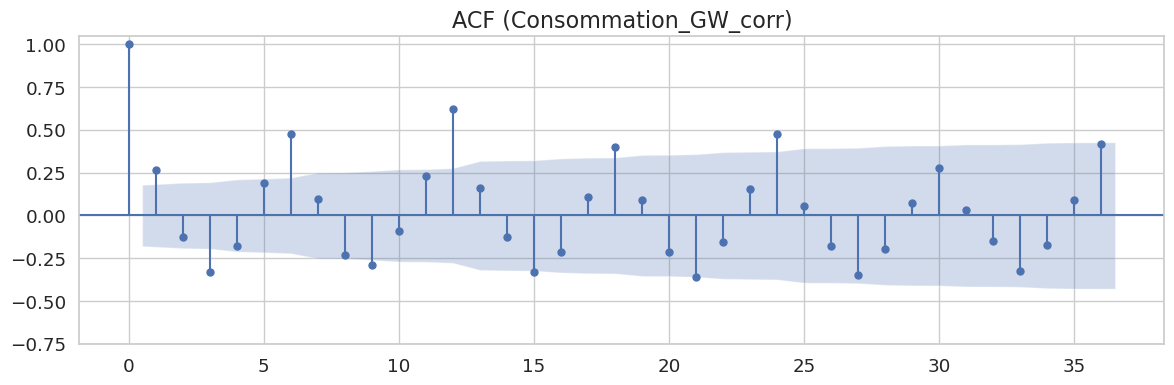

In [53]:
fig, ax = plt.subplots(figsize=(14, 4))
sgt.plot_acf(data['Consommation_GW_corr'], ax=ax, lags = nlag)
plt.title('ACF (Consommation_GW_corr)', size = 16)
plt.ylim(-.75, 1.05)
plt.show()

#### D'après l'autocorrélogramme simple, la différenciation classique (en tendance) ne semble pas appropriée, je vais utiliser une différenciation en saisonnalité de période 12.

In [54]:
# # Lag plots

# plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# # Plot
# # fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True, dpi=100)
# # for i, ax in enumerate(axes.flatten()[:4]):
# #     lag_plot(data['Consommation_GW'], lag=i+1, ax=ax, c='firebrick')
# #     ax.set_title('Lag ' + str(i+1))

# # fig.suptitle('', y=1.15) 

# fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True, dpi=100)
# for i, ax in enumerate(axes.flatten()[:4]):
#     lag_plot(data['Consommation_GW_corr'], lag=i+1, ax=ax, c='firebrick')
#     ax.set_title('Lag ' + str(i+1))

# fig.suptitle('Lag plots de Consommation_GW_corr', y=1.05)    
# plt.show()

# # Points get wide and scattered with increasing lag ==> lesser correlation

#### Différenciation en saisonnalité (ordre 12).

In [55]:
df_diff = data[['Consommation_GW_corr']].diff(12).dropna()
df_diff[:3]

,Consommation_GW_corr
Date,
2013-01-01,-3653.696137
2013-02-01,-6646.678281
2013-03-01,-3219.181945


#### ADF test

In [56]:
# Augmented Dickey-Fuller test

print(f"p-value = {sts.adfuller(df_diff, autolag='AIC')[1]}")

p-value = 0.04354113100608176


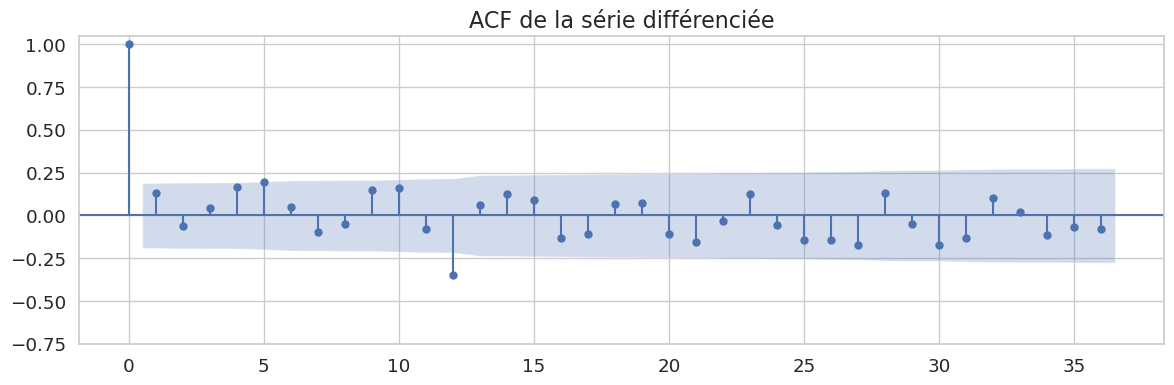

In [57]:
fig, ax = plt.subplots(figsize=(14, 4))
sgt.plot_acf(df_diff, ax=ax, lags = nlag)
plt.title('ACF de la série différenciée', size = 16)
plt.ylim(-.75, 1.05)
plt.show()

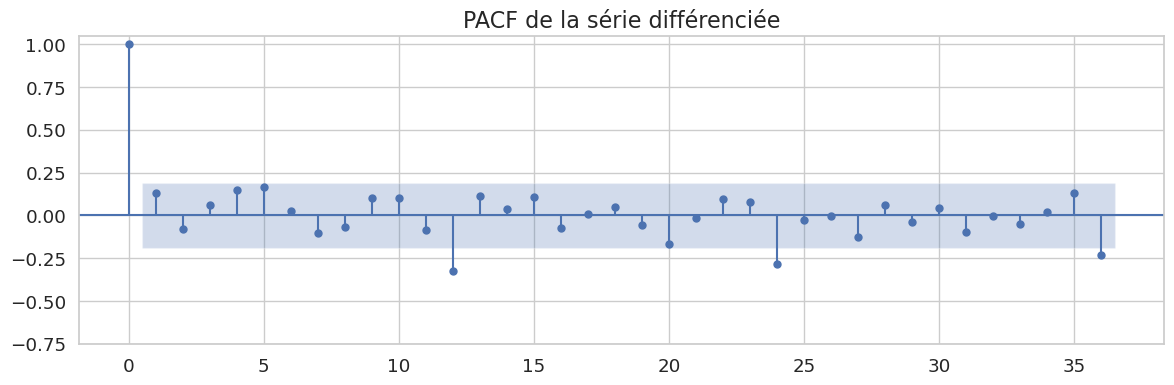

In [58]:
fig, ax = plt.subplots(figsize=(14, 4))
sgt.plot_pacf(df_diff, ax=ax, lags = nlag, method='ywm')
plt.title('PACF de la série différenciée', size = 16)
plt.ylim(-.75, 1.05)
plt.show()

In [59]:
# df_diff.mul(df_diff).plot(figsize=(22, 6))
# plt.title('Volatilité', fontsize=20)
# plt.show()

In [60]:
# start_date = '2018-01-01'
# end_date = '2021-12-01'

# test = pd.to_datetime(start_date) + pd.DateOffset(years=-1)
# test.strftime('%Y-%m-%d')

# <a name="M3">Mission 3</a>

## Effectuez une prévision de la consommation corrigée de l'effet température sur un an, en utilisant la méthode de Holt Winters puis la méthode Sarima.

In [61]:
# Estimate the forecastability of a time series
# https://en.wikipedia.org/wiki/Sample_entropy

rng = np.random.default_rng(1)
rand_small = rng.integers(0, 100, size=len(data))

"""Sample entropy"""

def SampEn(L, m, r):
    
    N = len(L)
    B = 0.0
    A = 0.0
    
    # Split time series and save all templates of length m
    xmi = np.array([L[i : i + m] for i in range(N - m)])
    xmj = np.array([L[i : i + m] for i in range(N - m + 1)])

    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])

    # Similar for computing A
    m += 1
    xm = np.array([L[i : i + m] for i in range(N - m + 1)])

    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])

    # Return SampEn
    return -np.log(A / B)

print(SampEn(data['Consommation_GW'], m=2, r=0.2*np.std(data['Consommation_GW'])))
print(SampEn(data['Consommation_GW_corr'], m=2, r=0.2*np.std(data['Consommation_GW_corr']))) 
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))

0.6066379376506628
1.8769172775683618
2.10684051586795


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2012-01-01 to 2021-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Consommation_GW       120 non-null    float64
 1   dju                   120 non-null    float64
 2   Consommation_GW_corr  120 non-null    float64
dtypes: float64(3)
memory usage: 7.8 KB


### Méthode de Holt Winters (lissage exponentiel)

In [63]:
hw = ExponentialSmoothing(data['Consommation_GW_corr'], seasonal_periods=12, trend=None, seasonal='add').fit(smoothing_level=0.5,
                                                                                                             smoothing_trend=0.5,
                                                                                                             smoothing_seasonal=0.5)

In [64]:
hw_predictions_corr = hw.predict(start='2021-01-01', end='2021-12-01')
hw.summary()

Dep. Variable:,Consommation_GW_corr,No. Observations:,120
Model:,ExponentialSmoothing,SSE,793401492.727
Optimized:,True,AIC,1912.522
Trend:,None,BIC,1951.547
Seasonal:,Additive,AICC,1917.803
Seasonal Periods:,12,Date:,"Wed, 21 Dec 2022"
Box-Cox:,False,Time:,16:07:25
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
smoothing_seasonal,0.5000000,gamma,False


In [65]:
# fig, ax = plt.subplots(figsize=(15, 10))
# _ = ax.set_title('Consommation d\'électricité corrigée vs prédiction', fontsize=20)
# _ = ax.plot(data['2021-01-01':'2021-12-01'].index, data['Consommation_GW_corr']['2021-01-01':'2021-12-01'], markersize=20, color='blue', linewidth=2, label='Consommation corrigée')
# _ = ax.plot(hw_predictions.index, hw_predictions, markersize=20, linestyle='dotted', color='green', label='Prévision (holt winters)')
# _ = ax.legend()

### Sarima (prévision de la série temporelle en se basant sur sa dynamique propre, c'est à dire son passé)

In [66]:
# pmdarima.arima.nsdiffs(data['Consommation_GW_corr'], m = 12, max_D=2, test='ocsb')

In [67]:
# kpss_diffs = pm.arima.ndiffs(data['Consommation_GW_corr'], alpha=0.05, test='kpss', max_d=6)
# adf_diffs = pm.arima.ndiffs(data['Consommation_GW_corr'], alpha=0.05, test='adf', max_d=6)
# n_diffs = max(adf_diffs, kpss_diffs)
# print(f'Estimated differencing term: {n_diffs}')

# # estimate number of seasonal differences using a Canova-Hansen test
# ch_nsdiffs = pm.arima.nsdiffs(data['Consommation_GW_corr'], m=12, max_D=12, test='ch') 
# # or use the OCSB test (by default)
# ocsb_nsdiffs = pm.arima.nsdiffs(data['Consommation_GW_corr'], m=12, max_D=12, test='ocsb')
# ns_diffs = max(ch_nsdiffs, ocsb_nsdiffs)
# print(f'Estimated seasonal differencing term: {ns_diffs}')

In [68]:
# start_time = time.time()
# print(f'--- {int((time.time() - start_time))} seconds ---')

model_auto = pm.auto_arima(data['Consommation_GW_corr'],
                           d=0, D=1, start_p=1, start_q=1,
                           m=12, # frequency of series
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=2031.388, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2025.913, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2027.886, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2027.926, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2025.048, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=2026.075, Time=0.11 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=2026.103, Time=0.07 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=2028.003, Time=0.34 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2027.804, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=2028.065, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12]          
Total fit time: 1.521 seconds


In [69]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  120
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood               -1011.524
Date:                  Wed, 21 Dec 2022   AIC                           2025.048
Time:                          16:07:27   BIC                           2027.730
Sample:                               0   HQIC                          2026.135
                                  - 120                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.908e+06   1.11e+06      7.141      0.000    5.74e+06    1.01e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.97   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.16   Prob(JB):                         0.95
Heteroskedasticity (H):               1.26   Skew:                             0.03
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
model = SARIMAX(data['Consommation_GW_corr'][:'2020-12-01'], order=(0, 0, 0), seasonal_order=(2, 1, 1, 12))
result = model.fit(maxiter=100)
predictions = result.predict(start='2021-01-01', end='2021-12-01')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26488D+01    |proj g|=  1.29348D+01

At iterate    5    f=  8.30698D+00    |proj g|=  8.43338D-04


 This problem is unconstrained.



At iterate   10    f=  8.30683D+00    |proj g|=  9.94861D-02

At iterate   15    f=  8.30343D+00    |proj g|=  2.33089D-01

At iterate   20    f=  8.29524D+00    |proj g|=  1.86042D-02

At iterate   25    f=  8.29273D+00    |proj g|=  2.01963D-02

At iterate   30    f=  8.29174D+00    |proj g|=  8.71657D-04

At iterate   35    f=  8.29143D+00    |proj g|=  1.34771D-02

At iterate   40    f=  8.29128D+00    |proj g|=  3.96062D-03

At iterate   45    f=  8.29124D+00    |proj g|=  2.42696D-03

At iterate   50    f=  8.29123D+00    |proj g|=  2.10466D-04

At iterate   55    f=  8.29120D+00    |proj g|=  6.33235D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [71]:
print(result.summary())

                                 SARIMAX Results                                  
Dep. Variable:       Consommation_GW_corr   No. Observations:                  108
Model:             SARIMAX(2, 1, [1], 12)   Log Likelihood                -895.449
Date:                    Wed, 21 Dec 2022   AIC                           1798.899
Time:                            16:07:28   BIC                           1809.156
Sample:                        01-01-2012   HQIC                          1803.045
                             - 12-01-2020                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.0134      0.014    -70.654      0.000      -1.042      -0.985
ar.S.L24      -0.0330      0.015     -2.266      0.023      -0.062      -0.004
ma.S.L12       1.000

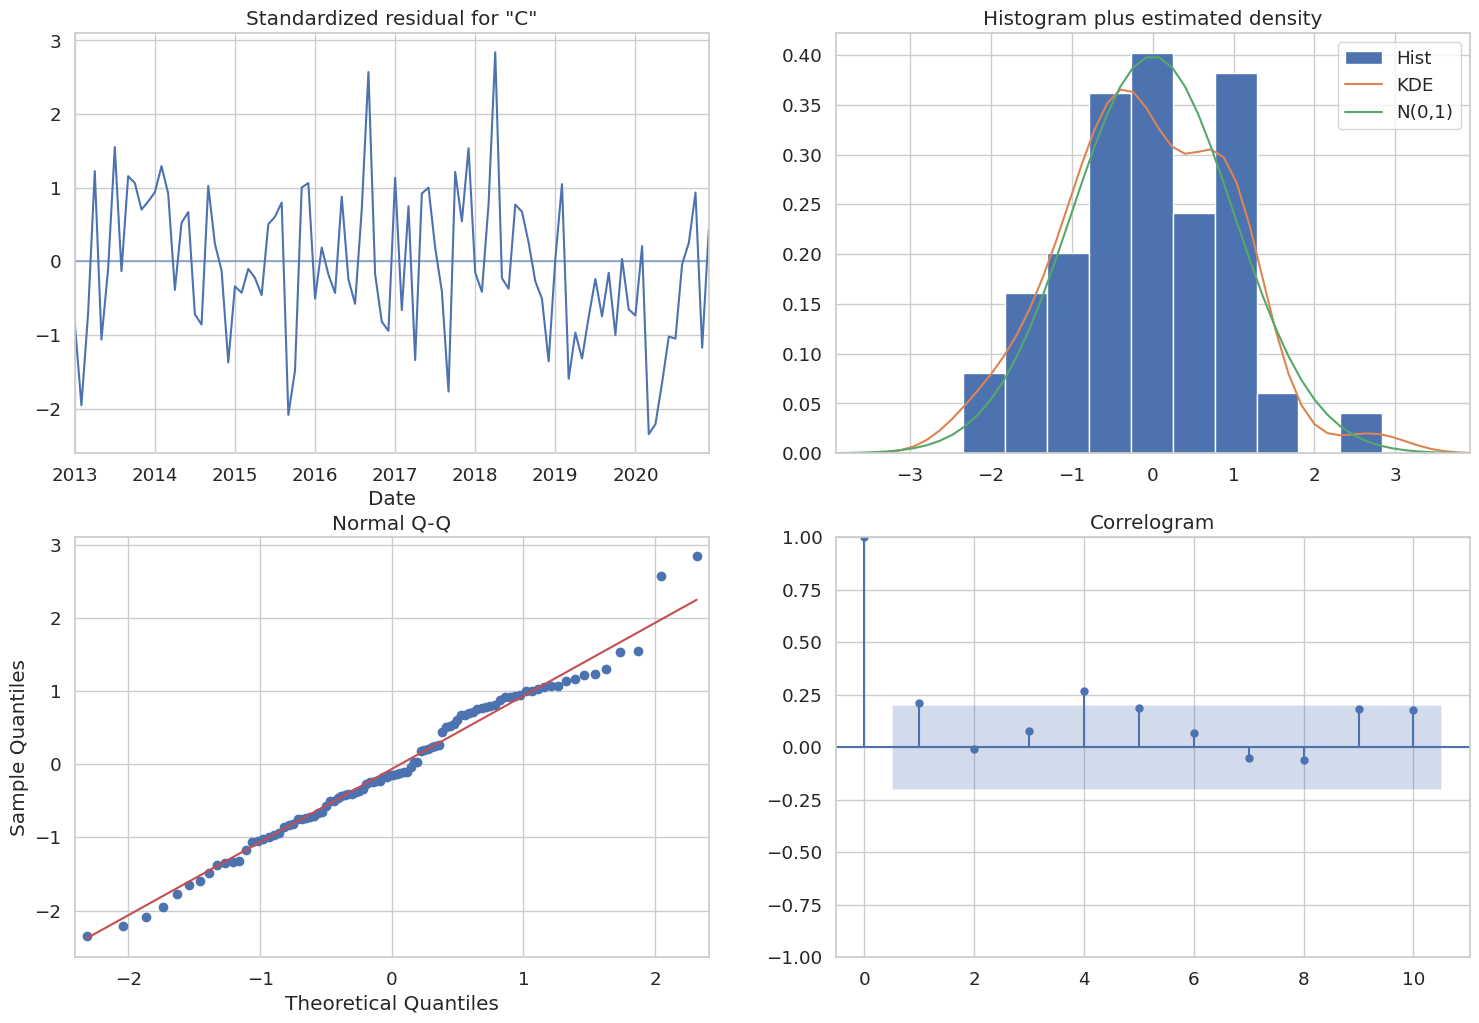

In [72]:
result.plot_diagnostics(figsize=(18, 12))
plt.show()

In [73]:
# Ljung-Box test, requires:
# stationarity
# white noise process has a normal distribution with mean zero

acorr_ljungbox(result.resid, lags=(6,12,18,24,30,36))

# Here, the null hypothesis for the Ljung-Box test is that there is no autocorrelation. 
# Looking at the p-values above, we can see that they are above 0.05. 
# Therefore, we cannot reject the null hypothesis, and the residuals are indeed not correlated, le test de blancheur n'est pas rejeté, le résidu est un bruit blanc.

,lb_stat,lb_pvalue
6,325.306940,3.071371e-67
12,366.035215,5.777079e-71
18,366.121987,1.028398e-66
24,366.209123,6.222742e-63
30,367.591261,9.398458e-60
36,369.718014,5.541312e-57


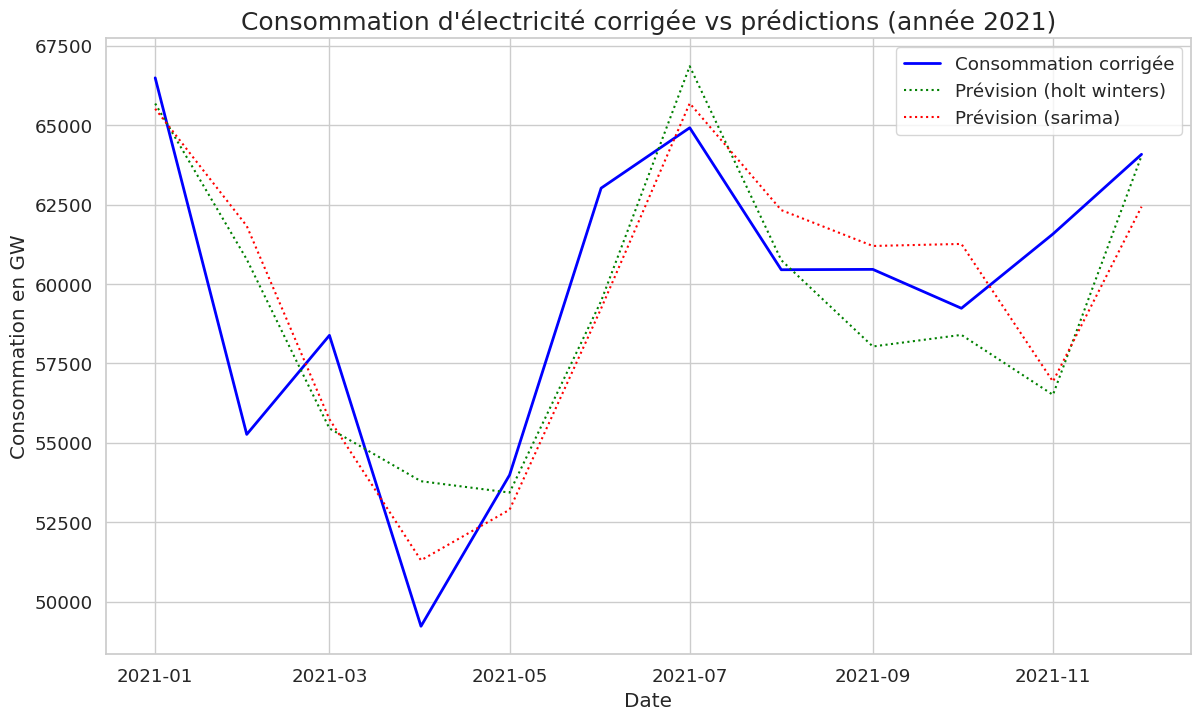

In [74]:
fig, ax = plt.subplots(figsize=(14, 8))
_ = ax.set_title('Consommation d\'électricité corrigée vs prédictions (année 2021)', fontsize=18)
_ = ax.plot(data['2021-01-01':'2021-12-01'].index, data['Consommation_GW_corr']['2021-01-01':'2021-12-01'], markersize=20, color='blue', linewidth=2, label='Consommation corrigée')
_ = ax.plot(hw_predictions_corr.index, hw_predictions_corr, markersize=20, linestyle='dotted', color='green', label='Prévision (holt winters)')
_ = ax.plot(predictions.index, predictions, markersize=20, linestyle='dotted', color='red', label='Prévision (sarima)')
_ = ax.set_xlabel('Date')
_ = ax.set_ylabel('Consommation en GW')
_ = ax.legend()
# plt.savefig('mission_3.png', transparent=True)
plt.show()

In [75]:
data

,Consommation_GW,dju,Consommation_GW_corr
Date,,,
2012-01-01,101573.076,361.5,68116.177168
2012-02-01,108364.070,468.6,64995.044294
2012-03-01,85891.077,241.4,63549.457697
2012-04-01,79899.382,254.3,56363.865062
2012-05-01,70077.667,104.6,60396.915637
...,...,...,...
2021-08-01,61095.998,7.0,60448.146570
2021-09-01,64161.309,40.0,60459.300830
2021-10-01,73117.128,150.0,59234.597364


In [76]:
spredictions = result.predict(start='2020-01-01', end='2021-12-01')

In [77]:
sgraph = data['2020-01-01':'2021-12-01'].copy()
sgraph['Prediction'] = spredictions

In [78]:
#sgraph.iloc[1:,]
sgraph

,Consommation_GW,dju,Consommation_GW_corr,Prediction
Date,,,,
2020-01-01,98880.317,367.0,64914.392045,66912.805425
2020-02-01,86231.667,270.1,61233.856835,60670.426666
2020-03-01,82566.154,297.9,54995.448158,61373.371084
2020-04-01,60943.600,111.7,50605.742187,56617.363828
2020-05-01,60948.453,94.3,52220.968740,56691.424927
2020-06-01,61213.145,27.3,58686.524424,61462.080918
2020-07-01,65517.378,3.9,65156.432203,68007.846116
2020-08-01,62378.181,6.5,61776.604672,61877.355838
2020-09-01,64222.979,39.7,60548.735892,59865.512830


In [79]:
# fig = plt.figure(figsize=(8, 6))
# ax = sns.regplot(data=sgraph, x='Consommation_GW_corr', y='Prediction', line_kws={'color':'red'})
# plt.title('Prédiction sarima vs actual', fontsize=20)
# plt.show()

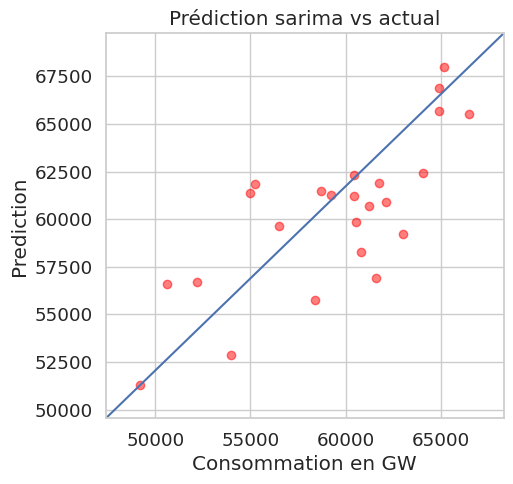

In [80]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.plot(sgraph['Consommation_GW_corr'], sgraph['Prediction'], marker='o', linestyle='', color='red', alpha=.5)
#_ = ax.axline((45000, 45000), slope=1)
_ = ax.axline([ax.get_xlim()[0], ax.get_ylim()[0]], [ax.get_xlim()[1], ax.get_ylim()[1]])
_ = ax.set_aspect('equal')
_ = ax.set(xlabel='Consommation en GW', ylabel='Prediction', title='Prédiction sarima vs actual')

plt.show()

In [81]:
# # Calcul RMSE

# error = rmse(data['Consommation_GW_corr']['2021-01-01':'2021-12-01'], hw_predictions_corr)
# # print('RMSE (holt winters): ', int(mse(data['Consommation_GW_corr']['2021-01-01':'2021-12-01'], hw_predictions_corr, squared=False)))
# # print('RMSE (sarima): ', int(mse(data['Consommation_GW_corr']['2021-01-01':'2021-12-01'], predictions, squared=False)))
# print(f'RMSE (holt winters): {int(error)}')
# # Comparaison avec l'écart type, RMSE doit être plus faible.
# print(f"Standard deviation : {int(np.std(data['Consommation_GW_corr']['2021-01-01':'2021-12-01']))}")

# error = rmse(data['Consommation_GW_corr']['2021-01-01':'2021-12-01'], predictions)
# print(f'\nRMSE (sarima): {int(error)}')

# # Comparaison avec l'écart type, RMSE doit être plus faible.
# print(f"Standard deviation : {int(np.std(data['Consommation_GW_corr']['2021-01-01':'2021-12-01']))}")

In [82]:
# # Calcul MAPE

# mape = (np.abs(1 - (hw_predictions_corr / data['Consommation_GW_corr']['2021-01-01':'2021-12-01']))).mean()*100
# print(f'MAPE (holt winters): {np.round(mape, 2)} %')
# print(f'Accuracy (holt winters): {100-np.round(mape, 2)} %')

# mape = (np.abs(1 - (predictions / data['Consommation_GW_corr']['2021-01-01':'2021-12-01']))).mean()*100
# print(f'\nMAPE (sarima): {np.round(mape, 2)} %')
# print(f'Accuracy (sarima): {100-np.round(mape, 2)} %')

In [83]:
# tableau des métriques

def metrics_timeseries(y_actual, y_pred):
    #y_actual, y_pred = np.array(y_actual), np.array(y_pred)
    diff = y_actual - y_pred
    mse = np.mean(diff**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(diff / y_actual)) * 100
    r2 = 1-(sum(diff**2)/sum((y_actual-np.mean(y_actual))**2))
    dict_metrics = {'Metric':['RMSE', 'MAPE','R²'], 'Result':np.round([rmse, mape, r2], 2)}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [84]:
df_metrics_SARIMA = metrics_timeseries(data['Consommation_GW_corr']['2021-01-01':'2021-12-01'], predictions)
df_metrics_holt_winters = metrics_timeseries(data['Consommation_GW_corr']['2021-01-01':'2021-12-01'], hw_predictions_corr)
df_compare = pd.merge(df_metrics_holt_winters, df_metrics_SARIMA, on='Metric').rename(columns={'Result_x':'Result Holt-Winters', 'Result_y':'Result Sarima'})
df_compare

,Metric,Result Holt-Winters,Result Sarima
0,RMSE,3020.46,2942.64
1,MAPE,4.11,4.10
2,R²,0.60,0.62


#### Le MAPE est < 5 %, ce qui est souhaitable dans le domaine de la prévision de la demande d'électricité.

# Bonus : modèle Sarimax, incorporation des dju comme variable exogène

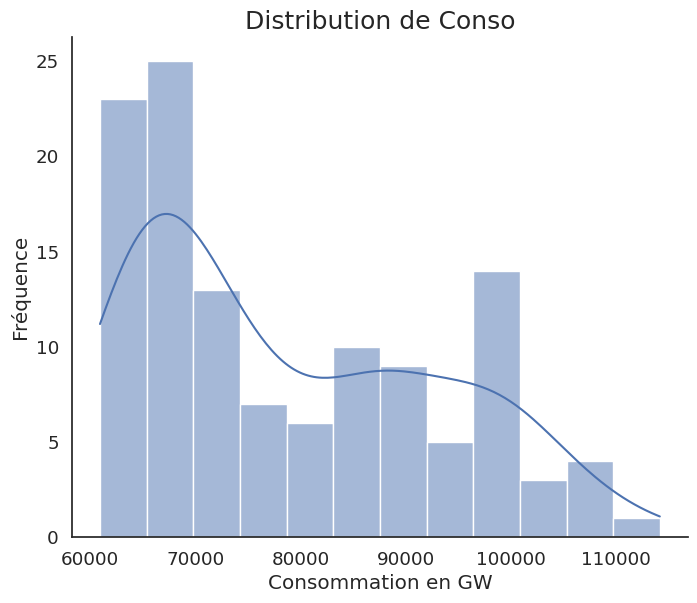

In [85]:
sns.set(font_scale=1.2, style='white')
sns.displot(data, x='Consommation_GW', log_scale=False, bins=12, height=6, aspect=1.2, kde=True)
plt.ylabel('Fréquence')
plt.xlabel('Consommation en GW')
plt.title('Distribution de Conso', fontsize=18)
plt.show()
sns.set(font_scale=1.2, style='whitegrid')

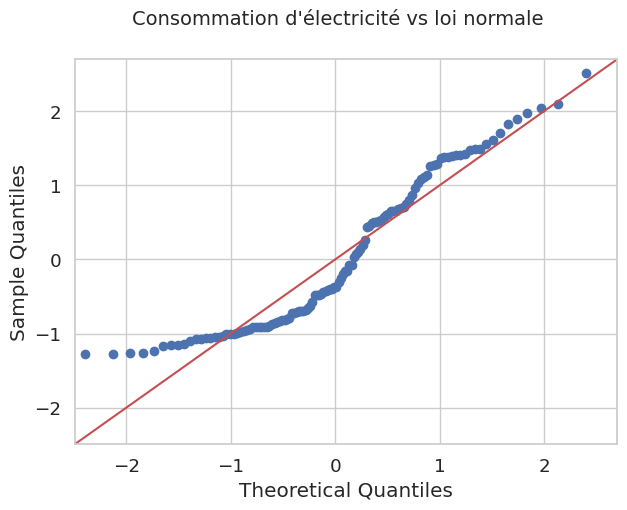

In [86]:
fig = sm.qqplot(data['Consommation_GW'], fit=True, line='45')
fig.set_size_inches(7, 5)
fig.suptitle('Consommation d\'électricité vs loi normale', fontsize=14)
plt.show()

In [87]:
print('Statistiques pour Consommation_GW :\n')
print(f"mean: {data['Consommation_GW'].mean()}")
print(f"median: {data['Consommation_GW'].median()}")
print(f"std: {data['Consommation_GW'].std()}")
print(f"skew: {data['Consommation_GW'].skew()}")
print(f"kurt: {data['Consommation_GW'].kurt()}")

Statistiques pour Consommation_GW :

mean: 78890.59515000001
median: 73676.2895
std: 14120.383257300147
skew: 0.5513922399947706
kurt: -0.9630135779769637


In [88]:
# A window-size equal to the seasonal duration (ex: 12 for a month-wise series), will effectively nullify the seasonal effect.

s_dec_additive = seasonal_decompose(data['Consommation_GW'], model = 'additive', extrapolate_trend='freq', period=12)

# fig = s_dec_additive.plot()
# fig.set_size_inches(22, 15)
# fig.tight_layout()
# plt.show()

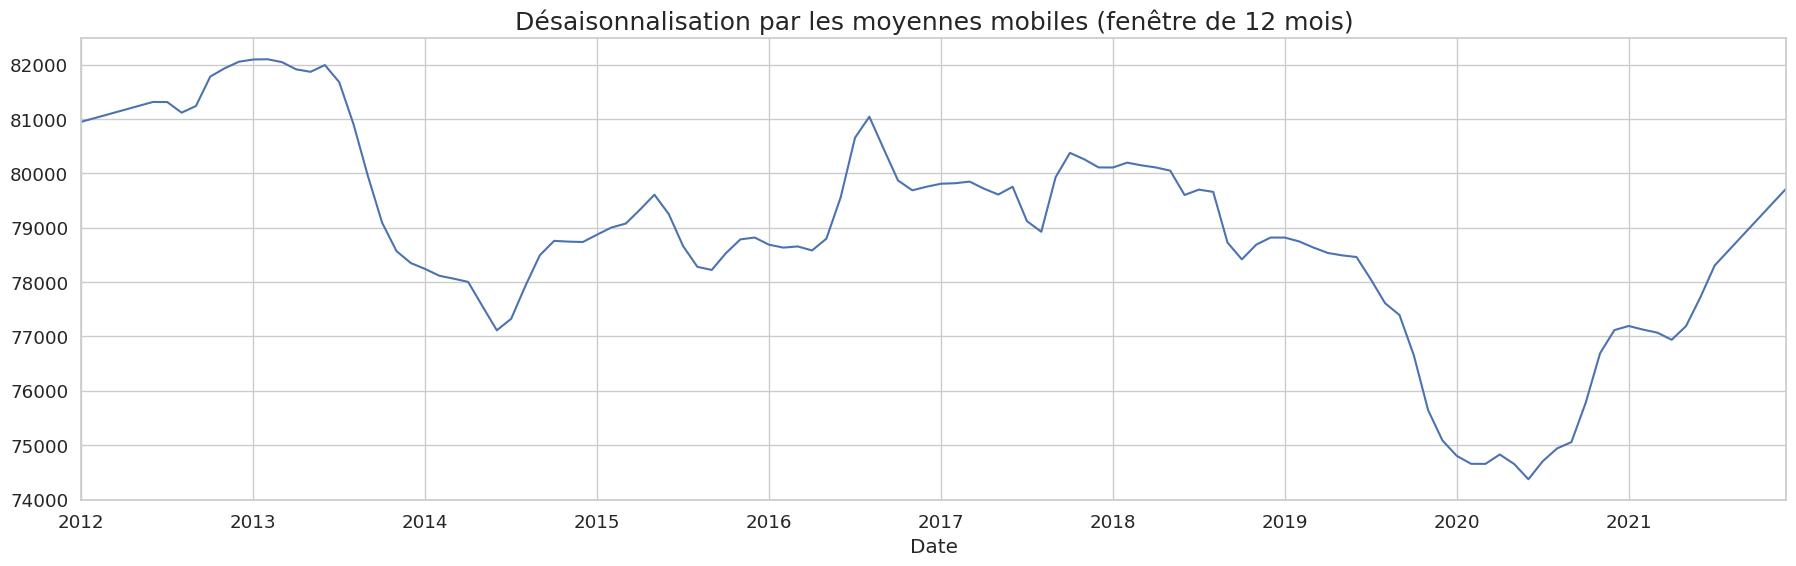

In [89]:
# Tendance

s_dec_additive.trend.plot(figsize=(22, 6))
plt.title('Désaisonnalisation par les moyennes mobiles (fenêtre de 12 mois)', fontsize=18)
plt.show()

- Il n'y a pas de tendance dans la série.
- On constate une hausse de la consommation en 2013 et une chute en 2020.

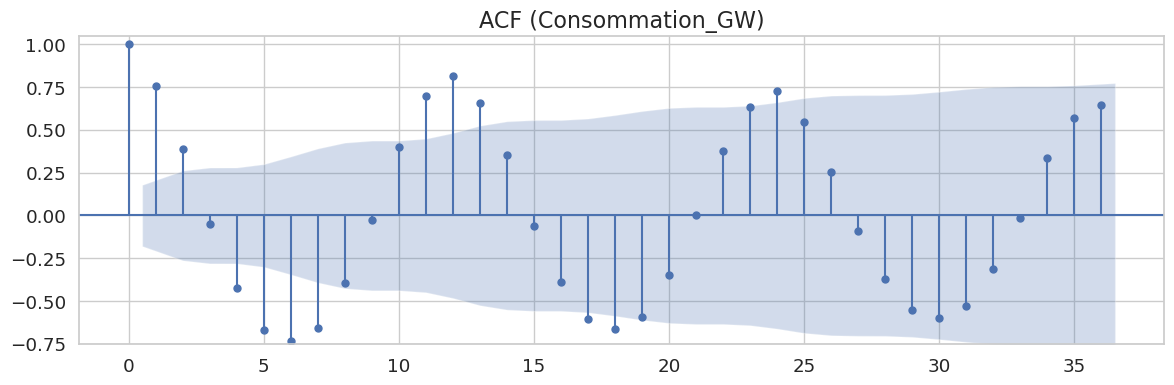

In [90]:
fig, ax = plt.subplots(figsize=(14, 4))
sgt.plot_acf(data['Consommation_GW'], ax=ax, lags = nlag)
plt.title('ACF (Consommation_GW)', size = 16)
plt.ylim(-.75, 1.05)
plt.show()

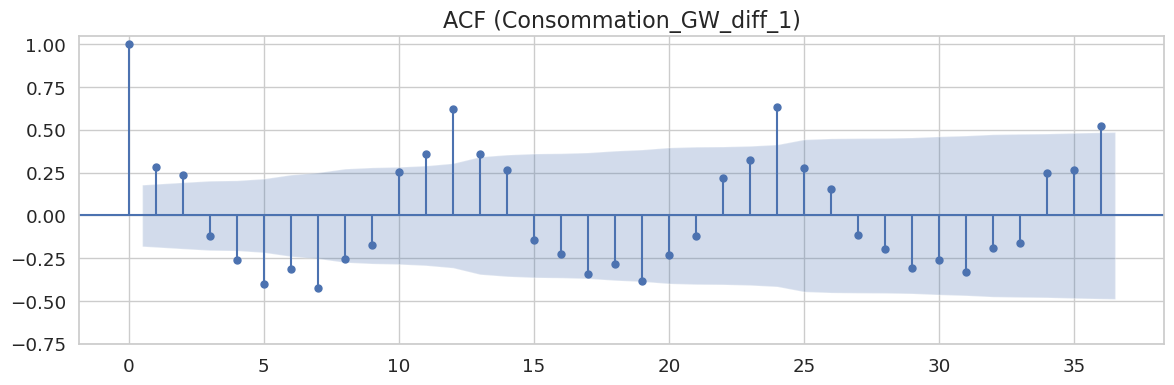

In [91]:
fig, ax = plt.subplots(figsize=(14, 4))
sgt.plot_acf(data['Consommation_GW'].diff(1).dropna(), ax=ax, lags = nlag)
plt.title('ACF (Consommation_GW_diff_1)', size = 16)
plt.ylim(-.75, 1.05)
plt.show()

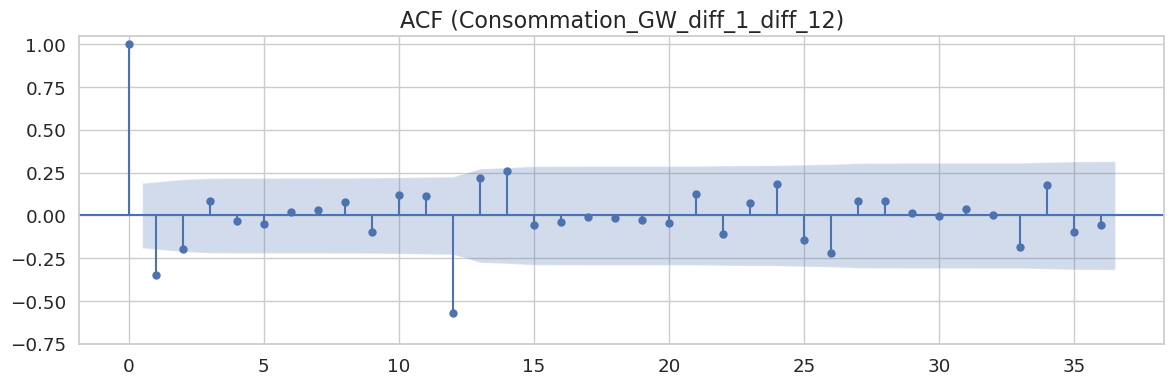

In [92]:
fig, ax = plt.subplots(figsize=(14, 4))
sgt.plot_acf(data['Consommation_GW'].diff(1).diff(12).dropna(), ax=ax, lags = nlag)
plt.title('ACF (Consommation_GW_diff_1_diff_12)', size = 16)
plt.ylim(-.75, 1.05)
plt.show()

In [93]:
# Augmented Dickey-Fuller test

result = sts.adfuller(data['Consommation_GW'].diff(1).diff(12).dropna(), autolag='AIC')
print(f'ADF test de Consommation_GW_corr:\np-value = {np.round(result[1], 2)}, la série est stationnaire.')

ADF test de Consommation_GW_corr:
p-value = 0.0, la série est stationnaire.


### Holt Winters (lissage exponentiel)

In [94]:
hw = ExponentialSmoothing(data['Consommation_GW'], seasonal_periods=12, trend=None, seasonal='add').fit(smoothing_level=0.5,
                                                                                                             smoothing_trend=0.5,
                                                                                                             smoothing_seasonal=0.5)
hw_predictions = hw.predict(start='2021-01-01', end='2021-12-01')
hw.summary()

Dep. Variable:,Consommation_GW,No. Observations:,120
Model:,ExponentialSmoothing,SSE,2880187235.942
Optimized:,True,AIC,2067.236
Trend:,None,BIC,2106.260
Seasonal:,Additive,AICC,2072.517
Seasonal Periods:,12,Date:,"Wed, 21 Dec 2022"
Box-Cox:,False,Time:,16:07:31
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
smoothing_seasonal,0.5000000,gamma,False


### Stationnarisation par différenciation

In [95]:
# ADF test
print(f"ADF test (Consommation_GW') p-value: {sts.adfuller(data['Consommation_GW'], autolag='AIC')[1]}")

ADF test (Consommation_GW') p-value: 0.3969455018927541


#### La série n'est pas stationnaire (p value > .05)

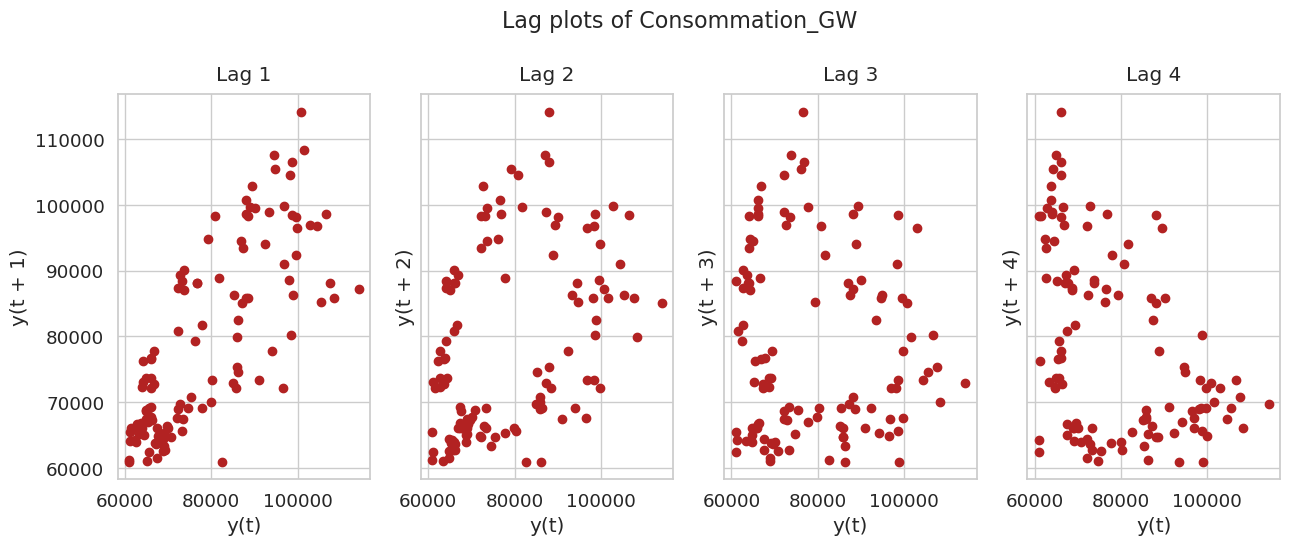

In [96]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(data['Consommation_GW'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))
    
fig.suptitle('Lag plots of Consommation_GW', y=1.05, fontsize=16)
plt.show()

# fig.suptitle('', y=1.15) 

# fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True, dpi=100)
# for i, ax in enumerate(axes.flatten()[:4]):
#     lag_plot(data['Consommation_GW_corr'], lag=i+1, ax=ax, c='firebrick')
#     ax.set_title('Lag ' + str(i+1))

# fig.suptitle('Lag plots of Consommation_GW_corr', y=1.05)    
# plt.show()

# Points get wide and scattered with increasing lag ==> lesser correlation

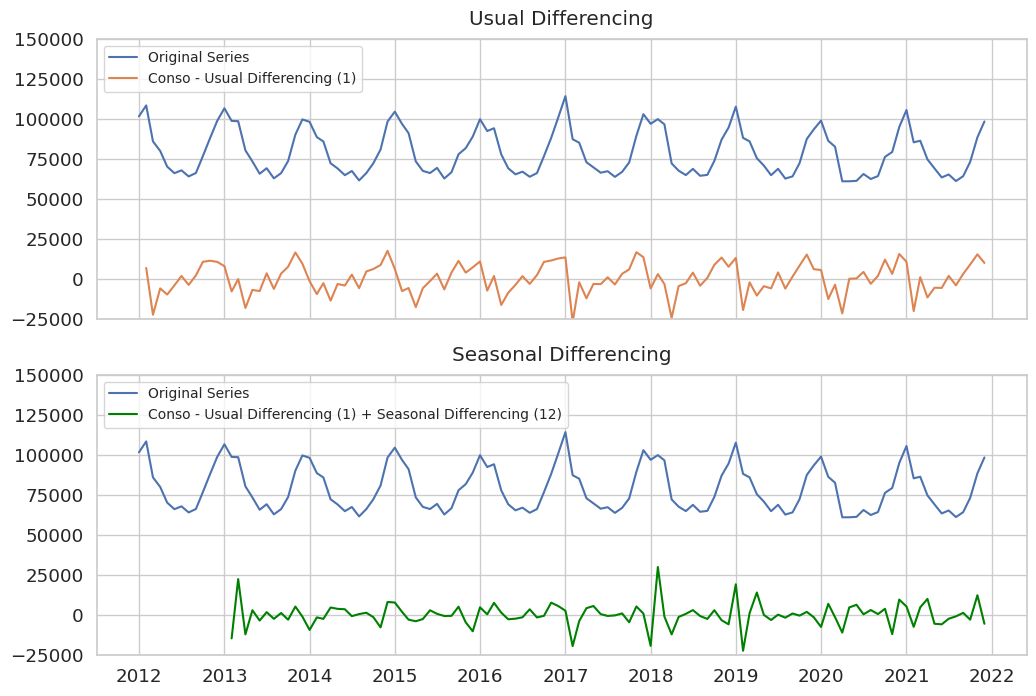

In [97]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data['Consommation_GW'], label='Original Series')
axes[0].plot(data['Consommation_GW'].diff(1), label='Conso - Usual Differencing (1)')
axes[0].set_ylim(-25000, 150000)
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasinal Dei
axes[1].plot(data['Consommation_GW'], label='Original Series')
axes[1].plot(data['Consommation_GW'].diff(1).diff(12), label='Conso - Usual Differencing (1) + Seasonal Differencing (12)', color='green')
axes[1].set_ylim(-25000, 150000)
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.show()

### Sarimax (prévision de la série temporelle en se basant sur sa dynamique propre, c'est à dire son passé, en ajoutant les dju comme variable exogène)

In [98]:
# kpss_diffs = pm.arima.ndiffs(data['Consommation_GW'], alpha=0.05, test='kpss', max_d=6)
# adf_diffs = pm.arima.ndiffs(data['Consommation_GW'], alpha=0.05, test='adf', max_d=6)
# n_diffs = max(adf_diffs, kpss_diffs)
# print(f'Estimated differencing term: {n_diffs}')

# # estimate number of seasonal differences using a Canova-Hansen test
# ch_nsdiffs = pm.arima.nsdiffs(data['Consommation_GW'], m=12, max_D=12, test='ch') 
# # or use the OCSB test (by default)
# ocsb_nsdiffs = pm.arima.nsdiffs(data['Consommation_GW'], m=12, max_D=12, test='ocsb')
# ns_diffs = max(ch_nsdiffs, ocsb_nsdiffs)
# print(f'Estimated seasonal differencing term: {ns_diffs}')

In [99]:
model_auto = pm.auto_arima(data['Consommation_GW'], exogenous=dju,
                           d=1, D=1, start_p=1, start_q=1,
                           m=12, # frequency of series
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2053.956, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2052.116, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2048.221, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2054.810, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2040.940, Time=0.91 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2038.816, Time=1.47 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2042.859, Time=1.15 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=2035.573, Time=0.68 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2038.505, Time=0.59 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=2038.067, Time=0.31 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.40 sec
 ARIMA(0,1,0)(0,1,1)[12]             : 

In [100]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood               -1012.786
Date:                                 Wed, 21 Dec 2022   AIC                           2035.573
Time:                                         16:07:47   BIC                           2048.937
Sample:                                     01-01-2012   HQIC                          2040.991
                                          - 12-01-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dju           79.3092      3.705     21.404      0.000      72.047      86.571
ar.S.L12      -0.7761      0.135     -5.756      0.000      -1.040      -0.512
ma.S.L12       0.5388      0.162      3.329      0.001       0.222       0.856
ma.S.L24      -0.2938      0.041     -7.098      0.000      -0.375      -0.213
sigma2      9.447e+06   1.28e-06   7.39e+12      0.000    9.45e+06    9.45e+06
===================================================================================
Ljung-Box (L1) (Q):                  14.29   Jarque-Bera (JB):                 1.52
Prob(Q):                              0.00   Prob(JB):                         0.47
Heteroskedasticity (H):               1.21   Skew:                            -0.29
Prob(H) (two-sided):                  0.56   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+29. Standard errors may be unstable.
"""

In [101]:
model = SARIMAX(data['Consommation_GW'][:'2020-12-01'], exog=dju[:'2020-12-01'], order=(0, 1, 0), seasonal_order=(0, 1, 2, 12))
result = model.fit()
predictions_max = result.predict(start='2021-01-01', end='2021-12-01', exog=dju['2021-01-01':'2021-12-01'])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42290D+00    |proj g|=  5.29299D-01


/home/ec2-user/.miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  8.33011D+00    |proj g|=  6.24523D-02

At iterate   10    f=  8.32872D+00    |proj g|=  5.48764D-04

At iterate   15    f=  8.32859D+00    |proj g|=  8.98123D-03

At iterate   20    f=  8.32844D+00    |proj g|=  6.07626D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   6.010D-05   8.328D+00
  F =   8.3284446317217213     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [102]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                         Consommation_GW   No. Observations:                  108
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -899.472
Date:                                 Wed, 21 Dec 2022   AIC                           1806.944
Time:                                         16:07:48   BIC                           1817.160
Sample:                                     01-01-2012   HQIC                          1811.072
                                          - 12-01-2020                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dju           79.8632      3.027     26.388      0.000      73.931      85.795
ma.S.L12      -0.3090      0.046     -6.693      0.000      -0.400      -0.219
ma.S.L24      -0.1978      0.031     -6.351      0.000      -0.259      -0.137
sigma2      7.875e+06   9.21e-07   8.55e+12      0.000    7.88e+06    7.88e+06
===================================================================================
Ljung-Box (L1) (Q):                  11.11   Jarque-Bera (JB):                 2.19
Prob(Q):                              0.00   Prob(JB):                         0.33
Heteroskedasticity (H):               0.92   Skew:                            -0.35
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.03e+28. Standard errors may be unstable.
"""

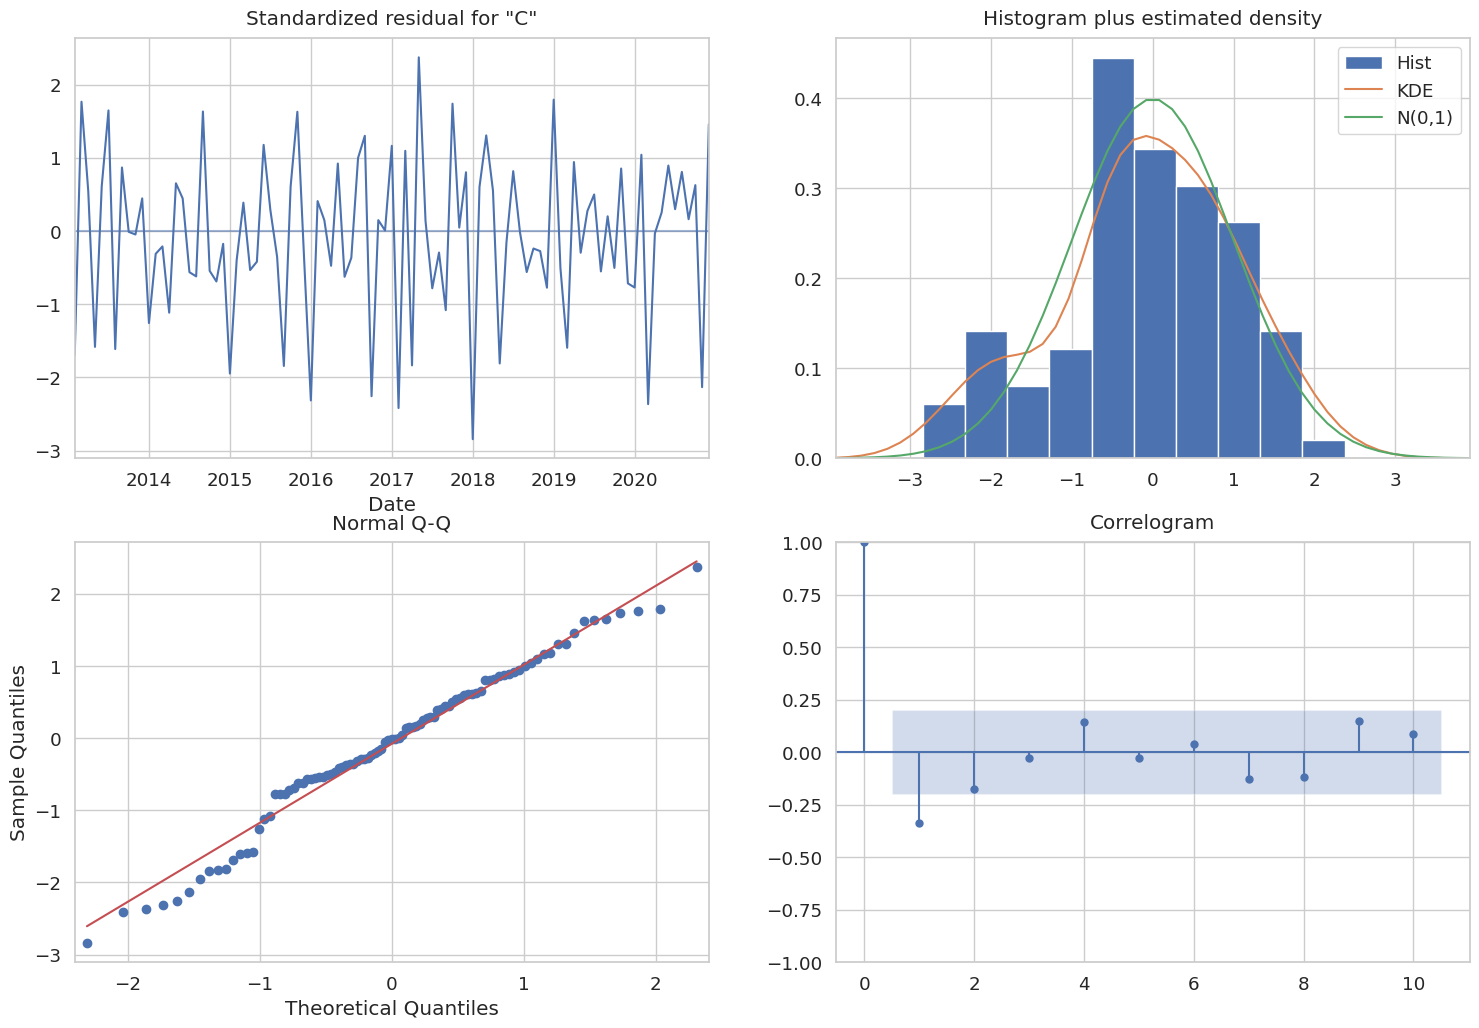

In [103]:
result.plot_diagnostics(figsize=(18, 12))
plt.show()

In [104]:
# fig, ax = plt.subplots(figsize=(15, 10))
# _ = ax.set_title('Consommation d\'électricité corrigée vs prédictions', fontsize=20)
# _ = ax.plot(data['Consommation_GW']['2021-01-01':'2021-12-01'].index, data['Consommation_GW']['2021-01-01':'2021-12-01'], markersize=20, color='blue', linewidth=2, label='Consommation corrigée')
# _ = ax.plot(predictions_max.index, predictions_max, markersize=20, linestyle='dotted', color='red', label='Prévision (sarima)')
# _ = ax.legend()

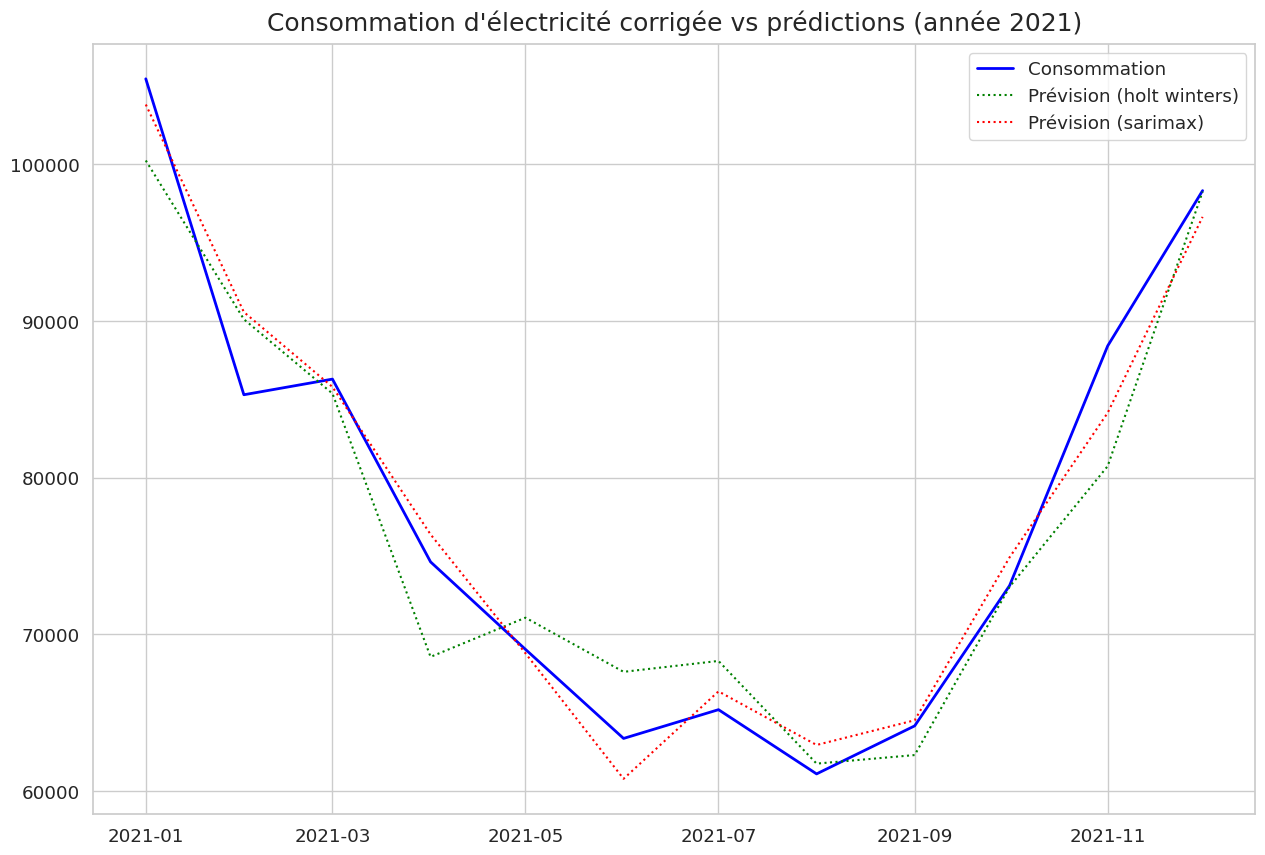

In [105]:
fig, ax = plt.subplots(figsize=(15, 10))
_ = ax.set_title('Consommation d\'électricité corrigée vs prédictions (année 2021)', fontsize=18)
_ = ax.plot(data['2021-01-01':'2021-12-01'].index, data['Consommation_GW']['2021-01-01':'2021-12-01'], markersize=20, color='blue', linewidth=2, label='Consommation')
_ = ax.plot(hw_predictions.index, hw_predictions, markersize=20, linestyle='dotted', color='green', label='Prévision (holt winters)')
_ = ax.plot(predictions_max.index, predictions_max, markersize=20, linestyle='dotted', color='red', label='Prévision (sarimax)')
_ = ax.legend()

In [106]:
error = rmse(data['Consommation_GW']['2021-01-01':'2021-12-01'], hw_predictions)
print(f'RMSE (holt winters): {int(error)}')

RMSE (holt winters): 3900


In [107]:
error = rmse(data['Consommation_GW']['2021-01-01':'2021-12-01'], predictions_max)
print(f'RMSE (sarimax): {int(error)}')

RMSE (sarimax): 2411


In [108]:
mape = (np.abs(1 - hw_predictions/data['Consommation_GW']['2021-01-01':'2021-12-01'])).mean()*100
print(f'MAPE (holt winters): {mape} %')
mape

MAPE (holt winters): 3.918715625108534 %


3.918715625108534

In [109]:
mape = (np.abs(1 - predictions_max/data['Consommation_GW']['2021-01-01':'2021-12-01'])).mean()*100
print(f'MAPE (sarimax): {mape} %')
mape

MAPE (sarimax): 2.4559569938890164 %


2.4559569938890164

In [112]:
df_metrics_holt_winters = metrics_timeseries(data['Consommation_GW']['2021-01-01':'2021-12-01'], hw_predictions)
df_metrics_SARIMAX = metrics_timeseries(data['Consommation_GW']['2021-01-01':'2021-12-01'], predictions_max)

df_compare = pd.merge(df_metrics_holt_winters, df_metrics_SARIMA, on='Metric').rename(columns={'Result_x':'Result Holt-Winters', 'Result_y':'Result Sarima'})
df_compare

df_compare = pd.merge(df_compare, df_metrics_SARIMAX, on='Metric').rename(columns={'Result':'Result Sarimax'})
df_compare

,Metric,Result Holt-Winters,Result Sarima,Result Sarimax
0,RMSE,3900.93,2942.64,2411.18
1,MAPE,3.92,4.10,2.46
2,R²,0.92,0.62,0.97


#### Le MAPE est < 5 %, ce qui est souhaitable dans le domaine de la prévision de la demande d'électricité.